# Using `IN_LEAGUE_NEXT` as our response variable

In this notebook we consider if we can predict `IN_LEAGUE_NEXT`, whether a given player will play _at any point_ (at hence appear in the stats data) during the next season.

In [210]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Load/inspect the data

- Load the data
- Drop the season with `SEASON_START=2023`, because we don't know yet if a player will play _at any point_ in the 2024 season
- Drop NAN values (mostly players without salary data).

In [213]:
df = pd.read_csv("Data/merged_data/merged_data_collapsed_teams.csv").dropna() #drop NAN rows
df = df[df["SEASON_START"] < 2023]

In [215]:
df.columns

Index(['NAME', 'PLAYER_ID', 'SEASON_START', 'TEAMS_LIST', 'PLAYER_AGE',
       'EXPERIENCE', 'POS', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS_PERCENT', 'X3P_AR', 'F_TR',
       'ORB_PERCENT', 'DRB_PERCENT', 'TRB_PERCENT', 'AST_PERCENT',
       'STL_PERCENT', 'BLK_PERCENT', 'TOV_PERCENT', 'USG_PERCENT', 'OWS',
       'DWS', 'WS', 'WS_48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Salary',
       'Percent_team_salary', 'WAIVED_OFF', 'WAIVED_REG', 'WAIVED_POST',
       'RELEASED_OFF', 'RELEASED_REG', 'RELEASED_POST', 'TRADED_OFF',
       'TRADED_REG', 'TRADED_POST', 'WAIVED_NEXT_OFF', 'WAIVED_NEXT_REG',
       'WAIVED_NEXT_POST', 'RELEASED_NEXT_OFF', 'RELEASED_NEXT_REG',
       'RELEASED_NEXT_POST', 'TRADED_NEXT_OFF', 'TRADED_NEXT_REG',
       'TRADED_NEXT_POST', 'WAIVED_NEXT_NEXT_OFF', 'RELEASED_NEXT_NEXT_OFF',
       'TRADED_NEXT_NEXT_OFF', 'WAIVED_NBA_YEAR'

# Feature engineering

We want:
- per-game counting stats (OREB, DREB, REB, AST, STL, BLK, TOV, PF, PTS)
- per-minute counting stats
- starts per game played
- $\log(\mathrm{PER}/\mathrm{PER}_{AVG})$, where $\mathrm{PER}_{AVG}=15$.

In [218]:
#per-game counting stats
df["OREB_PER_GAME"] = df["OREB"]/df["GP"]
df["DREB_PER_GAME"] = df["DREB"]/df["GP"]
df["REB_PER_GAME"]  = df["REB"]/df["GP"]
df["AST_PER_GAME"]  = df["AST"]/df["GP"]
df["STL_PER_GAME"]  = df["STL"]/df["GP"]
df["BLK_PER_GAME"]  = df["BLK"]/df["GP"]
df["TOV_PER_GAME"]  = df["TOV"]/df["GP"]
df["PF_PER_GAME"]   = df["PF"]/df["GP"]
df["PTS_PER_GAME"]  = df["PTS"]/df["GP"]

#per-minute counting stats
df["OREB_PER_MIN"] = df["OREB"]/df["MIN"]
df["DREB_PER_MIN"] = df["DREB"]/df["MIN"]
df["REB_PER_MIN"]  = df["REB"]/df["MIN"]
df["AST_PER_MIN"]  = df["AST"]/df["MIN"]
df["STL_PER_MIN"]  = df["STL"]/df["MIN"]
df["BLK_PER_MIN"]  = df["BLK"]/df["MIN"]
df["TOV_PER_MIN"]  = df["TOV"]/df["MIN"]
df["PF_PER_MIN"]   = df["PF"]/df["MIN"]
df["PTS_PER_MIN"]  = df["PTS"]/df["MIN"]

#starts per game played
df["STARTS_PER_GP"] = df["GS"]/df["GP"]

In [220]:
def compute_log_PER(x):
    #some players have PER <=0.  Map these players to LOG_PER = -6,
    #chosen based on the distribution (see plot below)
    BAD_PLAYER_VAL = -6

    #PER is defined so that the league average is 15
    PER_AVG = 15.0

    if x.PER <= 0:
        return BAD_PLAYER_VAL #player is very bad

    return np.log(x.PER/PER_AVG)

df["LOG_PER"] = df.apply(compute_log_PER, axis=1)

Text(0, 0.5, 'Counts')

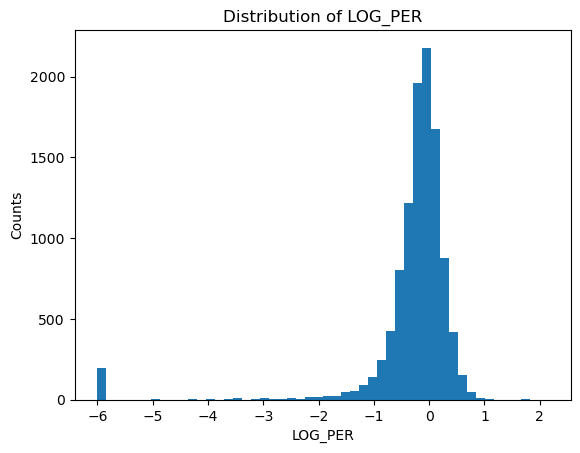

In [222]:
plt.hist(df["LOG_PER"].to_numpy(), bins=50);
plt.title("Distribution of LOG_PER")
plt.xlabel("LOG_PER")
plt.ylabel("Counts")

In [224]:
#grab all columns as a list
all_columns = list(df.columns)

#grab just the numerical features (drop NAME, PLAYER_ID, POS)
features = [all_columns[2]] + all_columns[4:6] + all_columns[7:]

print(features)

['SEASON_START', 'PLAYER_AGE', 'EXPERIENCE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS_PERCENT', 'X3P_AR', 'F_TR', 'ORB_PERCENT', 'DRB_PERCENT', 'TRB_PERCENT', 'AST_PERCENT', 'STL_PERCENT', 'BLK_PERCENT', 'TOV_PERCENT', 'USG_PERCENT', 'OWS', 'DWS', 'WS', 'WS_48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Salary', 'Percent_team_salary', 'WAIVED_OFF', 'WAIVED_REG', 'WAIVED_POST', 'RELEASED_OFF', 'RELEASED_REG', 'RELEASED_POST', 'TRADED_OFF', 'TRADED_REG', 'TRADED_POST', 'WAIVED_NEXT_OFF', 'WAIVED_NEXT_REG', 'WAIVED_NEXT_POST', 'RELEASED_NEXT_OFF', 'RELEASED_NEXT_REG', 'RELEASED_NEXT_POST', 'TRADED_NEXT_OFF', 'TRADED_NEXT_REG', 'TRADED_NEXT_POST', 'WAIVED_NEXT_NEXT_OFF', 'RELEASED_NEXT_NEXT_OFF', 'TRADED_NEXT_NEXT_OFF', 'WAIVED_NBA_YEAR', 'WAIVED_NEXT_NBA_YEAR', 'RELEASED_NBA_YEAR', 'RELEASED_NEXT_NBA_YEAR', 'TRADED_NBA_YEAR', 'TRADED_NEXT_NBA_YEAR', 'IN_LEAGUE_NEXT', 'OREB

## Compute correlations

In [227]:
corr = df[features].corr()

In [229]:
abs(corr["IN_LEAGUE_NEXT"]).sort_values(ascending=False)

IN_LEAGUE_NEXT            1.000000
GP                        0.472782
WAIVED_NBA_YEAR           0.469802
MIN                       0.427562
PF                        0.422214
FGA                       0.367229
WAIVED_REG                0.366768
FGM                       0.366102
PTS                       0.361907
TOV                       0.355213
DREB                      0.349597
STL                       0.349345
REB                       0.344105
PF_PER_GAME               0.342294
DWS                       0.340731
PTS_PER_GAME              0.336097
WS                        0.328559
LOG_PER                   0.324547
GS                        0.316117
WAIVED_NEXT_OFF           0.315338
FTA                       0.311212
OBPM                      0.307224
DREB_PER_GAME             0.304798
FTM                       0.303476
STARTS_PER_GP             0.300884
BPM                       0.300680
REB_PER_GAME              0.296703
STL_PER_GAME              0.294883
TOV_PER_GAME        

In [231]:
#Note that ~84% of players have IN_LEAGUE_NEXT = 1, so we have imbalanced classes 
print(df.IN_LEAGUE_NEXT.value_counts(normalize=False), '\n')
print(df.IN_LEAGUE_NEXT.value_counts(normalize=True))

IN_LEAGUE_NEXT
1.0    8967
0.0    1744
Name: count, dtype: int64 

IN_LEAGUE_NEXT
1.0    0.837177
0.0    0.162823
Name: proportion, dtype: float64


# Training a simple classifier

We can see that `IN_LEAGUE_NEXT` is potentially a good response variable for two reasons:
- it has reasonably high correlations with the predictor data (with, e.g., `GP`, `PF`, `PCT_TEAM_SALARY`)
- it describes the future state of a player, so predicting it using just current-season stats data is interesting.

Predicting whether or not a player is in the league next year is also reasonably interesting, and training an interpretable model (like the logistic regression model below) can give us some hints as to what fringe NBA players could do to increase their odds of staying in the league.

In [234]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split

In [236]:
#let's be careful here: some of the columns in the dataframe include future data.  Let's just use
#current-season stats and salary data
predictors = features[0:46] + features[74:]

print(predictors)

['SEASON_START', 'PLAYER_AGE', 'EXPERIENCE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS_PERCENT', 'X3P_AR', 'F_TR', 'ORB_PERCENT', 'DRB_PERCENT', 'TRB_PERCENT', 'AST_PERCENT', 'STL_PERCENT', 'BLK_PERCENT', 'TOV_PERCENT', 'USG_PERCENT', 'OWS', 'DWS', 'WS', 'WS_48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Salary', 'Percent_team_salary', 'OREB_PER_GAME', 'DREB_PER_GAME', 'REB_PER_GAME', 'AST_PER_GAME', 'STL_PER_GAME', 'BLK_PER_GAME', 'TOV_PER_GAME', 'PF_PER_GAME', 'PTS_PER_GAME', 'OREB_PER_MIN', 'DREB_PER_MIN', 'REB_PER_MIN', 'AST_PER_MIN', 'STL_PER_MIN', 'BLK_PER_MIN', 'TOV_PER_MIN', 'PF_PER_MIN', 'PTS_PER_MIN', 'STARTS_PER_GP', 'LOG_PER']


In [238]:
#make train-test split
X_train, X_test, y_train, y_test = train_test_split(df[predictors], df.IN_LEAGUE_NEXT, 
                                                    test_size=0.1, random_state=815, shuffle=True, stratify=df.IN_LEAGUE_NEXT.values)

In [240]:
#oversample the rare class (waived players)
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek


#it seems like SMOTE (generating synthetic data for players with IN_LEAGUE_NEXT=0) works better than
#randomly oversampling, randomly undersampling, and combined methods (SMOTEENN, SMOTETomek)
smote = SMOTE(random_state=5)
X_train_re, y_train_re = smote.fit_resample(X_train, y_train)

#ros = RandomOverSampler(random_state=5)
#X_train_re, y_train_re = ros.fit_resample(X_train, y_train)

#rus = RandomUnderSampler(random_state=5)
#X_train_re, y_train_re = rus.fit_resample(X_train, y_train)

#smoteenn = SMOTEENN(random_state=5)
#X_train_re, y_train_re = smoteenn.fit_resample(X_train, y_train)

#smotetomek = SMOTETomek(random_state=5)
#X_train_re, y_train_re = smotetomek.fit_resample(X_train, y_train)

Accuracy:    0.85
Precision:   0.93
Recall:      0.88
NPV:         0.53
Specificity: 0.66


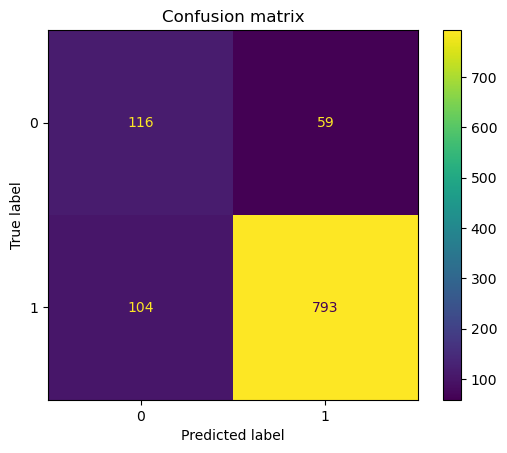

In [264]:
lr = Pipeline([("scale", StandardScaler()), ("log_reg", LogisticRegression(penalty=None, max_iter=10_000))])
lr.fit(X_train_re, y_train_re)
preds    = lr.predict(X_test)

accuracy  = accuracy_score(y_test, preds)
conf      = confusion_matrix(y_test, preds)
#grab true negatives, true positives, false positives, false negatives
tn = conf[0,0]
tp = conf[1,1]
fp = conf[0,1]
fn = conf[1,0]

#precision (positive predictive value): what % of players classified as 1's are true 1's?
precision   = tp/(tp+fp)
#recall (sensitivity): what % of true 1's are classified as 1?
recall      = tp/(tp+fn)
#negative predictive value (NPV): what % of players classified as 0's are true 0's?
npv         = tn/(tn+fn)
#specificity: what % of true 0's are classified as 0?
specificity = tn/(tn+fp)

print(f"Accuracy:    {accuracy:.2f}")
print(f"Precision:   {precision:.2f}")
print(f"Recall:      {recall:.2f}")
print(f"NPV:         {npv:.2f}")
print(f"Specificity: {specificity:.2f}")

ConfusionMatrixDisplay(conf).plot()
plt.title("Confusion matrix")
plt.show()

To briefly summarize: the performance is reasonably good.  The classifier is really good ($\sim 90\%$ precision and recall) at correctly guessing when a player will stay in the league (which is the majority class, about $84\%$ of all rows), and slightly better than random chance when a player is going to be out of the league ($\sim 60\%$ recall and NPV).

Note that we only used stats and salary data!  We could also include predictors like draft position if a player was drafted and whether or not a player has been previously traded or waived.  To see which additional predictors could be useful, we need to **look at the false positives and false negatives** to see why our model is guessing wrong.

## Investigating misclassified rows

Let's add a column to `df` with the model's prediction, `MODEL_PRED`.  Then we can consider false positives and false negatives, and see why they get misclassified.

In [246]:
df["MODEL_PRED"] = lr.predict(df[predictors])

### Inspecting false positives

Let's now look at false positives: players the model think should be in the NBA next season, who don't end up playing.

In [257]:
df.loc[ (df["IN_LEAGUE_NEXT"]==0) & (df["MODEL_PRED"]==1) ].sample(5, random_state=815)[["NAME"] + predictors]

,NAME,SEASON_START,PLAYER_AGE,EXPERIENCE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PER,TS_PERCENT,X3P_AR,F_TR,ORB_PERCENT,DRB_PERCENT,TRB_PERCENT,AST_PERCENT,STL_PERCENT,BLK_PERCENT,TOV_PERCENT,USG_PERCENT,OWS,DWS,WS,WS_48,OBPM,DBPM,BPM,VORP,Salary,Percent_team_salary,OREB_PER_GAME,DREB_PER_GAME,REB_PER_GAME,AST_PER_GAME,STL_PER_GAME,BLK_PER_GAME,TOV_PER_GAME,PF_PER_GAME,PTS_PER_GAME,OREB_PER_MIN,DREB_PER_MIN,REB_PER_MIN,AST_PER_MIN,STL_PER_MIN,BLK_PER_MIN,TOV_PER_MIN,PF_PER_MIN,PTS_PER_MIN,STARTS_PER_GP,LOG_PER
221,Mahmoud Abdul-Rauf,1997,29.0,8,31,0.0,530.0,103,273,0.377,5.0,31.0,0.161,16,16,1.000,6.0,31.0,37.0,58,16.0,1.0,19.0,31,227,10.5,0.405,0.114,0.059,1.2,6.7,3.9,19.7,1.6,0.1,6.4,25.1,-0.5,0.2,-0.3,-0.025,-3.2,-1.5,-4.7,-0.4,3300000.0,0.109830,0.193548,1.000000,1.193548,1.870968,0.516129,0.032258,0.612903,1.000000,7.322581,0.011321,0.058491,0.069811,0.109434,0.030189,0.001887,0.035849,0.058491,0.428302,0.000000,-0.356675
8001,David Harrison,2007,25.0,4,55,0.0,702.0,90,170,0.529,0.0,0.0,0.000,49,96,0.510,43.0,75.0,118.0,14,20.0,59.0,58.0,164,229,8.6,0.539,0.000,0.565,6.5,11.9,9.1,3.0,1.4,6.3,21.5,16.7,-0.5,0.9,0.4,0.030,-7.3,1.4,-5.9,-0.7,1734316.0,0.026174,0.781818,1.363636,2.145455,0.254545,0.363636,1.072727,1.054545,2.981818,4.163636,0.061254,0.106838,0.168091,0.019943,0.028490,0.084046,0.082621,0.233618,0.326211,0.000000,-0.556288
4829,Charles Shackleford,1992,27.0,4,48,0.0,568.0,80,164,0.488,0.0,2.0,0.000,31,49,0.633,65.0,140.0,205.0,26,13.0,25.0,36.0,92,191,13.1,0.515,0.012,0.299,12.4,26.6,19.6,6.9,1.1,2.6,16.2,16.5,0.2,0.7,0.9,0.073,-2.9,-0.4,-3.3,-0.2,1720000.0,0.099038,1.354167,2.916667,4.270833,0.541667,0.270833,0.520833,0.750000,1.916667,3.979167,0.114437,0.246479,0.360915,0.045775,0.022887,0.044014,0.063380,0.161972,0.336268,0.000000,-0.135438
4184,Matt Maloney,2000,29.0,5,55,27.0,1401.0,146,348,0.420,51.0,142.0,0.359,26,34,0.765,14.0,103.0,117.0,154,56.0,5.0,70.0,94,369,10.4,0.508,0.408,0.098,1.1,8.2,4.6,17.6,2.1,0.3,16.2,13.8,0.7,0.8,1.5,0.053,-1.4,0.5,-0.9,0.4,611000.0,0.015548,0.254545,1.872727,2.127273,2.800000,1.018182,0.090909,1.272727,1.709091,6.709091,0.009993,0.073519,0.083512,0.109921,0.039971,0.003569,0.049964,0.067095,0.263383,0.490909,-0.366244
1785,Kevin Gamble,1996,31.0,10,62,2.0,954.0,123,286,0.430,54.0,112.0,0.482,7,10,0.700,13.0,94.0,107.0,77,21.0,17.0,27.0,76,307,11.6,0.529,0.392,0.035,1.6,11.6,6.5,12.9,1.2,1.3,8.5,14.9,1.1,0.6,1.6,0.082,-0.2,-0.1,-0.3,0.4,1196000.0,0.042990,0.209677,1.516129,1.725806,1.241935,0.338710,0.274194,0.435484,1.225806,4.951613,0.013627,0.098532,0.112159,0.080713,0.022013,0.017820,0.028302,0.079665,0.321803,0.032258,-0.257045


### Inspecting false negatives

Let's now look at false negatives: players the model thinks should be out of the league, who manage to hang on.

In [260]:
df.loc[ (df["IN_LEAGUE_NEXT"]==1) & (df["MODEL_PRED"]==0) ].sample(5, random_state=815)[["NAME"] + predictors]

,NAME,SEASON_START,PLAYER_AGE,EXPERIENCE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PER,TS_PERCENT,X3P_AR,F_TR,ORB_PERCENT,DRB_PERCENT,TRB_PERCENT,AST_PERCENT,STL_PERCENT,BLK_PERCENT,TOV_PERCENT,USG_PERCENT,OWS,DWS,WS,WS_48,OBPM,DBPM,BPM,VORP,Salary,Percent_team_salary,OREB_PER_GAME,DREB_PER_GAME,REB_PER_GAME,AST_PER_GAME,STL_PER_GAME,BLK_PER_GAME,TOV_PER_GAME,PF_PER_GAME,PTS_PER_GAME,OREB_PER_MIN,DREB_PER_MIN,REB_PER_MIN,AST_PER_MIN,STL_PER_MIN,BLK_PER_MIN,TOV_PER_MIN,PF_PER_MIN,PTS_PER_MIN,STARTS_PER_GP,LOG_PER
3286,Ricky Pierce,1994,35.0,13,27,6.0,673.0,111,254,0.437,23.0,70.0,0.329,93,106,0.877,12.0,52.0,64.0,40,22.0,2.0,24.0,38,338,15.1,0.562,0.276,0.417,2.0,8.6,5.3,9.2,1.6,0.2,7.4,20.4,1.3,0.2,1.5,0.107,0.2,-0.7,-0.5,0.2,2500000.0,0.126280,0.444444,1.925926,2.370370,1.481481,0.814815,0.074074,0.888889,1.407407,12.518519,0.017831,0.077266,0.095097,0.059435,0.032689,0.002972,0.035661,0.056464,0.502229,0.222222,0.006645
10910,Danny Green,2010,24.0,2,8,0.0,92.0,17,35,0.486,7.0,19.0,0.368,0,0,0.000,3.0,12.0,15.0,2,2.0,1.0,5.0,7,41,13.2,0.586,0.543,0.000,3.9,14.8,9.5,3.6,1.1,0.8,12.5,20.0,0.0,0.1,0.1,0.076,0.1,-0.7,-0.6,0.0,94154.0,0.001354,0.375000,1.500000,1.875000,0.250000,0.250000,0.125000,0.625000,0.875000,5.125000,0.032609,0.130435,0.163043,0.021739,0.021739,0.010870,0.054348,0.076087,0.445652,0.000000,-0.127833
13699,Gary Payton II,2018,26.0,3,3,0.0,16.0,5,8,0.625,1.0,2.0,0.500,0,0,0.000,1.0,1.0,2.0,4,3.0,1.0,1.0,2,11,36.9,0.688,0.250,0.000,6.7,6.9,6.8,45.1,8.9,5.3,11.1,23.8,0.1,0.0,0.1,0.358,8.3,10.6,18.9,0.1,85457.0,0.000691,0.333333,0.333333,0.666667,1.333333,1.000000,0.333333,0.333333,0.666667,3.666667,0.062500,0.062500,0.125000,0.250000,0.187500,0.062500,0.062500,0.125000,0.687500,0.000000,0.900161
1571,Lindsey Hunter,2003,33.0,11,33,8.0,659.0,49,143,0.343,14.0,50.0,0.280,5,8,0.625,13.0,54.0,67.0,85,39.0,6.0,34.0,45,117,9.0,0.399,0.350,0.056,2.3,9.3,5.9,20.7,3.2,0.7,18.8,12.8,-0.4,1.3,0.9,0.067,-3.4,3.1,-0.2,0.3,3000000.0,0.056135,0.393939,1.636364,2.030303,2.575758,1.181818,0.181818,1.030303,1.363636,3.545455,0.019727,0.081942,0.101669,0.128983,0.059181,0.009105,0.051593,0.068285,0.177542,0.242424,-0.510826
14726,Amir Coffey,2019,23.0,1,18,1.0,159.0,23,54,0.426,6.0,19.0,0.316,6,11,0.545,4.0,12.0,16.0,14,5.0,2.0,8.0,20,58,8.5,0.493,0.352,0.204,2.7,7.6,5.2,12.3,1.5,1.1,12.0,17.6,0.0,0.2,0.1,0.041,-4.3,0.1,-4.1,-0.1,79568.0,0.000605,0.222222,0.666667,0.888889,0.777778,0.277778,0.111111,0.444444,1.111111,3.222222,0.025157,0.075472,0.100629,0.088050,0.031447,0.012579,0.050314,0.125786,0.364780,0.055556,-0.567984
